### 2023-07-07 vertically resolved heating rates

In [1]:
import os
import dataclasses
import datetime
import cftime
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from vcm.fv3.metadata import standardize_fv3_diagnostics
from vcm.catalog import catalog as CATALOG
from vcm.interpolate import interpolate_to_pressure_levels
from vcm.select import zonal_average_approximate
from vcm.convenience import convert_timestamps

In [2]:
@dataclasses.dataclass
class HeatingRate:
    standard_name: str
    python_name: str
        
HEATING_RATES = [
    HeatingRate(
        'tendency_of_air_temperature_due_to_shortwave_heating_assuming_clear_sky',
        'clear_sky_shortwave_heating_rate_python'
    ),
    HeatingRate(
        'tendency_of_air_temperature_due_to_shortwave_heating',
        'total_sky_shortwave_heating_rate_python'
    ),
    HeatingRate(
        'tendency_of_air_temperature_due_to_longwave_heating_assuming_clear_sky',
        'clear_sky_longwave_heating_rate_python'
    ),
    HeatingRate(
        'tendency_of_air_temperature_due_to_longwave_heating',
        'total_sky_longwave_heating_rate_python'
    )
]

In [3]:
RADIATION_RUNS = {
    'baseline_coarse_nudged': 'gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run',
    'coarsened_fine_cloud': 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run',
    'ml_cloud': 'gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0/fv3gfs_run',
    'ml_cloud_thresholded': 'gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0.065/fv3gfs_run',
}
COARSENED_FINE_DIAGNOSTICS_KEY = '10day_c48_PIRE_ccnorm_physics_tendencies_may2023'
COARSENED_FINE_STATE_KEY= '10day_c48_PIRE_ccnorm_restarts_as_zarr_may2023'
GRID = CATALOG['grid/c48'].to_dask()
TIME_SLICE = slice(
    cftime.DatetimeJulian(2020, 8, 7, 0, 30, 0, 0),
    cftime.DatetimeJulian(2020, 8, 9, 23, 30, 0, 0),
    4
) # hourly days 8-10 validation
SECONDS_PER_DAY = 86_400.
plt.rcParams['font.size'] = 8
OUTDIR = 'figures_supplemental'

In [4]:
def add_cre(heating_rates):
    rate_names = 'longwave', 'shortwave'
    cre_dataset = xr.Dataset()
    for rate_name in rate_names:
        total_rate_name = f"tendency_of_air_temperature_due_to_{rate_name}_heating"
        clear_rate_name = f"tendency_of_air_temperature_due_to_{rate_name}_heating_assuming_clear_sky"
        cre_rate_name = f"{rate_name}_cloud_radiative_effect_rate"
        cre_rate = (heating_rates[total_rate_name] - heating_rates[clear_rate_name]).assign_attrs(
            {
                'long_name': cre_rate_name.replace('_', ''), 'units': 'K/s'
            }
        )
        cre_dataset[cre_rate_name] = cre_rate
    return heating_rates.merge(cre_dataset)

def shift_time(ds, time_shift, dt_seconds):
    '''Shift time coordinate by interpolating forward half a step.
    xarray interp loads the entire dataset but this doesn't.'''
    with xr.set_options(keep_attrs=True):
        ds = (ds + ds.shift(time=time_shift)) / 2
    ds = ds.assign_coords({
        'time': ds.time + datetime.timedelta(seconds=((-time_shift * dt_seconds) / 2))
    })
    return ds

def get_reference_heating_rates(key, heating_rates=HEATING_RATES):
    ds = standardize_fv3_diagnostics(CATALOG[key].to_dask())
    reference_heating_rates = xr.Dataset()
    for heating_rate in heating_rates:
        if heating_rate.standard_name in ds.data_vars:
            reference_heating_rates[heating_rate.standard_name] = ds[heating_rate.standard_name]
    reference_heating_rates = add_cre(reference_heating_rates)
    reference_heating_rates = shift_time(reference_heating_rates, time_shift=-1, dt_seconds=900)
    return reference_heating_rates

def get_coarse_heating_rates(rundir, zarrname='radiative_fluxes.zarr', heating_rates=HEATING_RATES):
    full_path = os.path.join(rundir, zarrname)
    print(full_path)
    ds = xr.open_zarr(full_path)
    coarse_heating_rates = xr.Dataset()
    for heating_rate in heating_rates:
        if heating_rate.python_name in ds.data_vars:
            coarse_heating_rates[heating_rate.standard_name] = ds[heating_rate.python_name]
    coarse_heating_rates = coarse_heating_rates.isel(z=slice(None, None, -1)) # python port is reversed in z
    return add_cre(coarse_heating_rates)

def zonal_heating_rates(heating_rates, delp):
    coords = ['z', 'y', 'x', 'tile']
    heating_rates_pressure = interpolate_to_pressure_levels(
        heating_rates.drop_vars(coords, errors='ignore'),
        delp.drop_vars(coords, errors='ignore'),
        dim='z'
    )
    heating_rates_pressure = heating_rates_pressure.assign_coords({
        'pressure': (heating_rates_pressure.pressure / 100).assign_attrs({
            'long_name': 'pressure', 'units': 'hPa'
        })
    })
    zonal_heating_rates = zonal_average_approximate(GRID.lat, heating_rates_pressure, lat_name='latitude')
    zonal_heating_rates = zonal_heating_rates.assign_coords({
        'latitude': np.sin(np.deg2rad(zonal_heating_rates.latitude)).assign_attrs({
            'long_name': 'latitude', 'units': '$\degree$'
        })
    })
    for var in zonal_heating_rates:
        zonal_heating_rates[var]  = (SECONDS_PER_DAY * zonal_heating_rates[var]).assign_attrs(
            {'long_name': var.replace('_', ' '), 'units': 'K/day'}
        )
    return zonal_heating_rates

def get_coarse_delp(rundir):
    full_path = os.path.join(rundir, 'state_after_timestep.zarr')
    ds = xr.open_zarr(full_path)
    return ds['pressure_thickness_of_atmospheric_layer']

def get_reference_delp(key):
    ds = CATALOG[key].to_dask()
    ds = standardize_fv3_diagnostics(ds.assign_coords({'time': convert_timestamps(ds.time)}))
    return ds.delp.rename('pressure_thickness_of_vertical_layer')

def weighted_rms(da, weights, dims):
    numerator = ((da ** 2) * weights).sum(dim=dims)
    denominator = weights.sum(dim=dims)
    rms = np.sqrt(numerator / denominator)
    return rms.assign_attrs(da.attrs)

def plot_zonal_average(zonal_average, ax, weights, run_name, **plot_kwargs):
    h = zonal_average.plot(y='pressure', yincrease=False, ax=ax, rasterized=True, **plot_kwargs)
    mean = zonal_average.weighted(weights).mean(dim=['pressure', 'latitude'])
    rms = weighted_rms(zonal_average, weights, dims=['pressure', 'latitude'])
    ax.set_title(f"{run_name}\nmean: {mean.item():0.4f}, RMS: {rms.item():0.4f}")
    ax.set_xticks(np.sin(np.deg2rad(np.arange(-60, 90, 30))))
    ax.set_xticklabels([f"{lat:d}" for lat in range(-60, 90, 30)])
    ax.set_yticks([200, 600, 1000])
    return h

In [5]:
reference_heating_rates = get_reference_heating_rates(COARSENED_FINE_DIAGNOSTICS_KEY).sel(time=TIME_SLICE)
reference_delp = get_reference_delp(COARSENED_FINE_STATE_KEY).sel(time=TIME_SLICE)
reference_heating_rates_zonal = zonal_heating_rates(reference_heating_rates, reference_delp)

coarse_delp = get_coarse_delp(RADIATION_RUNS['baseline_coarse_nudged']).sel(time=TIME_SLICE)
coarse_heating_rates_zonal = []
for name, path in RADIATION_RUNS.items():
    _coarse_heating_rates = get_coarse_heating_rates(path).sel(time=TIME_SLICE)
    _coarse_heating_rates_zonal = zonal_heating_rates(_coarse_heating_rates, coarse_delp)
    coarse_heating_rates_zonal.append(_coarse_heating_rates_zonal.expand_dims({'run': [name]}))
coarse_heating_rates_zonal = xr.concat(coarse_heating_rates_zonal, dim='run')

heating_rate_biases_zonal = xr.Dataset()
with xr.set_options(keep_attrs=True):
    for var in coarse_heating_rates_zonal.data_vars:
        heating_rate_biases_zonal[var] = (
            coarse_heating_rates_zonal[var] - reference_heating_rates_zonal[var]
        ).assign_attrs({'long_name': f"{coarse_heating_rates_zonal[var].attrs.get('long_name', var)} bias"})
        
with ProgressBar():
    reference_cre_rates_zonal_time_mean = reference_heating_rates_zonal[[
        'shortwave_cloud_radiative_effect_rate',
        'longwave_cloud_radiative_effect_rate'
    ]].mean('time').compute()
    
    heating_rate_biases_zonal_time_mean = heating_rate_biases_zonal[[
        'shortwave_cloud_radiative_effect_rate',
        'longwave_cloud_radiative_effect_rate'
    ]].mean('time').compute()

gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0.065/fv3gfs_run/radiative_fluxes.zarr
[########################################] | 100% Completed | 137.97 s
[########################################] | 100% Completed | 12m 28s


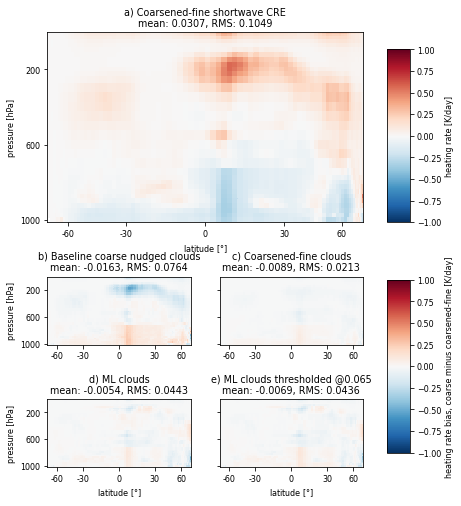

In [6]:
reference_pressure_thicknesses = xr.DataArray(
    np.concatenate([np.diff(reference_cre_rates_zonal_time_mean.pressure.values), [13.]]),
    dims=['pressure'],
    coords={'pressure': reference_cre_rates_zonal_time_mean.pressure}
)
cos_lat = np.cos(reference_cre_rates_zonal_time_mean.latitude * (2 * np.pi / 360.))
zonal_mean_weights = (
    reference_pressure_thicknesses
    *
    np.cos(reference_cre_rates_zonal_time_mean.latitude * (2 * np.pi / 360.))
)

plot_kwargs = dict(vmin=-1.0)
fig = plt.figure()
gs = GridSpec(4, 2, figure=fig, hspace=0.8)
ax0 = fig.add_subplot(gs[0:2, 0:2])
href = plot_zonal_average(
    reference_cre_rates_zonal_time_mean.shortwave_cloud_radiative_effect_rate,
    ax=ax0,
    weights=zonal_mean_weights,
    run_name='a) Coarsened-fine shortwave CRE',
    add_colorbar=False,
    **plot_kwargs
)
ax1 = fig.add_subplot(gs[2, 0])
hbias = plot_zonal_average(
    heating_rate_biases_zonal_time_mean.shortwave_cloud_radiative_effect_rate.sel(run='baseline_coarse_nudged'),
    ax=ax1,
    weights=zonal_mean_weights,
    run_name='b) Baseline coarse nudged clouds',
    add_colorbar=False,
    **plot_kwargs
)
ax1.set_xlabel(None)
ax2 = fig.add_subplot(gs[2, 1])
hbias = plot_zonal_average(
    heating_rate_biases_zonal_time_mean.shortwave_cloud_radiative_effect_rate.sel(run='coarsened_fine_cloud'),
    ax=ax2,
    weights=zonal_mean_weights,
    run_name='c) Coarsened-fine clouds',
    add_colorbar=False,
    **plot_kwargs
)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticklabels([])
ax3 = fig.add_subplot(gs[3, 0])
plot_zonal_average(
    heating_rate_biases_zonal_time_mean.shortwave_cloud_radiative_effect_rate.sel(run='ml_cloud'),
    ax=ax3,
    weights=zonal_mean_weights,
    run_name='d) ML clouds',
    add_colorbar=False,
    **plot_kwargs
)
ax4 = fig.add_subplot(gs[3, 1])
plot_zonal_average(
    heating_rate_biases_zonal_time_mean.shortwave_cloud_radiative_effect_rate.sel(run='ml_cloud_thresholded'),
    ax=ax4,
    weights=zonal_mean_weights,
    run_name='e) ML clouds thresholded @0.065',
    add_colorbar=False,
    **plot_kwargs
)
ax4.set_ylabel(None)
ax4.set_yticklabels([])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.3])
fig.colorbar(href, cax=cbar_ax, label='heating rate [K/day]')
cbar_ax2 = fig.add_axes([0.85, 0.15, 0.05, 0.3])
fig.colorbar(hbias, cax=cbar_ax2, label='heating rate bias, coarse minus coarsened-fine [K/day]')
fig.set_size_inches([6.5, 8])
fig.savefig(f'{OUTDIR}/shortwave_CRE_heating_rate_biases.eps', bbox_inches='tight')

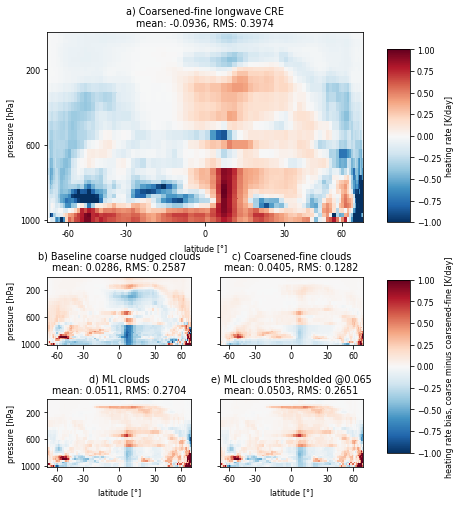

In [7]:
fig = plt.figure()
gs = GridSpec(4, 2, figure=fig, hspace=0.8)
ax0 = fig.add_subplot(gs[0:2, 0:2])
href = plot_zonal_average(
    reference_cre_rates_zonal_time_mean.longwave_cloud_radiative_effect_rate,
    ax=ax0,
    weights=zonal_mean_weights,
    run_name='a) Coarsened-fine longwave CRE',
    add_colorbar=False,
    **plot_kwargs
)
ax1 = fig.add_subplot(gs[2, 0])
hbias = plot_zonal_average(
    heating_rate_biases_zonal_time_mean.longwave_cloud_radiative_effect_rate.sel(run='baseline_coarse_nudged'),
    ax=ax1,
    weights=zonal_mean_weights,
    run_name='b) Baseline coarse nudged clouds',
    add_colorbar=False,
    **plot_kwargs
)
ax1.set_xlabel(None)
ax2 = fig.add_subplot(gs[2, 1])
hbias = plot_zonal_average(
    heating_rate_biases_zonal_time_mean.longwave_cloud_radiative_effect_rate.sel(run='coarsened_fine_cloud'),
    ax=ax2,
    weights=zonal_mean_weights,
    run_name='c) Coarsened-fine clouds',
    add_colorbar=False,
    **plot_kwargs
)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticklabels([])
ax3 = fig.add_subplot(gs[3, 0])
plot_zonal_average(
    heating_rate_biases_zonal_time_mean.longwave_cloud_radiative_effect_rate.sel(run='ml_cloud'),
    ax=ax3,
    weights=zonal_mean_weights,
    run_name='d) ML clouds',
    add_colorbar=False,
    **plot_kwargs
)
ax4 = fig.add_subplot(gs[3, 1])
plot_zonal_average(
    heating_rate_biases_zonal_time_mean.longwave_cloud_radiative_effect_rate.sel(run='ml_cloud_thresholded'),
    ax=ax4,
    weights=zonal_mean_weights,
    run_name='e) ML clouds thresholded @0.065',
    add_colorbar=False,
    **plot_kwargs
)
ax4.set_ylabel(None)
ax4.set_yticklabels([])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.3])
fig.colorbar(href, cax=cbar_ax, label='heating rate [K/day]')
cbar_ax2 = fig.add_axes([0.85, 0.15, 0.05, 0.3])
fig.colorbar(hbias, cax=cbar_ax2, label='heating rate bias, coarse minus coarsened-fine [K/day]')
fig.set_size_inches([6.5, 8])
fig.savefig(f'{OUTDIR}/longwave_CRE_heating_rate_biases.eps', bbox_inches='tight')